In [2]:
# docker環境から該当フォルダへ移動
import os
os.chdir('work/23_interpreting_ML/')

In [22]:
import sys
import warnings
from dataclasses import dataclass
from typing import Any  # 型ヒント用
from __future__ import annotations  # 型ヒント用

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib  # matplotlibの日本語表示対応

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance


# 自作モジュール
sys.path.append("..")
from mli.visualize import get_visualization_setting
from chapter3_pfi import PermutationFeatureImportance

np.random.seed(42)
pd.options.display.float_format = "{:.2f}".format
sns.set(**get_visualization_setting())
warnings.simplefilter("ignore")  # warningsを非表示に

### 特徴量重要度は因果関係として解釈できるか？

In [9]:
def generate_simulation_data(N, beta, mu, Sigma):
    """線形のシミュレーションデータを生成し、訓練データとテストデータに分割する
    
    Args: 
        N: インスタンスの数
        beta: 各特徴量の傾き
        mu: 各特徴量は多変量正規分布から生成される。その平均。
        Sigma: 各特徴量は多変量正規分布から生成される。その分散共分散行列。
    """

    # 多変量正規分布からデータを生成する
    X = np.random.multivariate_normal(mu, Sigma, N)

    # ノイズは平均0標準偏差0.1(分散は0.01)で決め打ち
    epsilon = np.random.normal(0, 0.1, N)

    # 特徴量とノイズの線形和で目的変数を作成
    y = X @ beta + epsilon

    return train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# シミュレーションデータの設定
N = 1000
J = 3
mu = np.zeros(J)
Sigma = np.array([[1, 0.95, 0], [0.95, 1, 0], [0, 0, 1]])
beta = np.array([1, 0, 0])

# シミュレーションデータの生成
X_train, X_test, y_train, y_test = generate_simulation_data(N, beta, mu, Sigma)

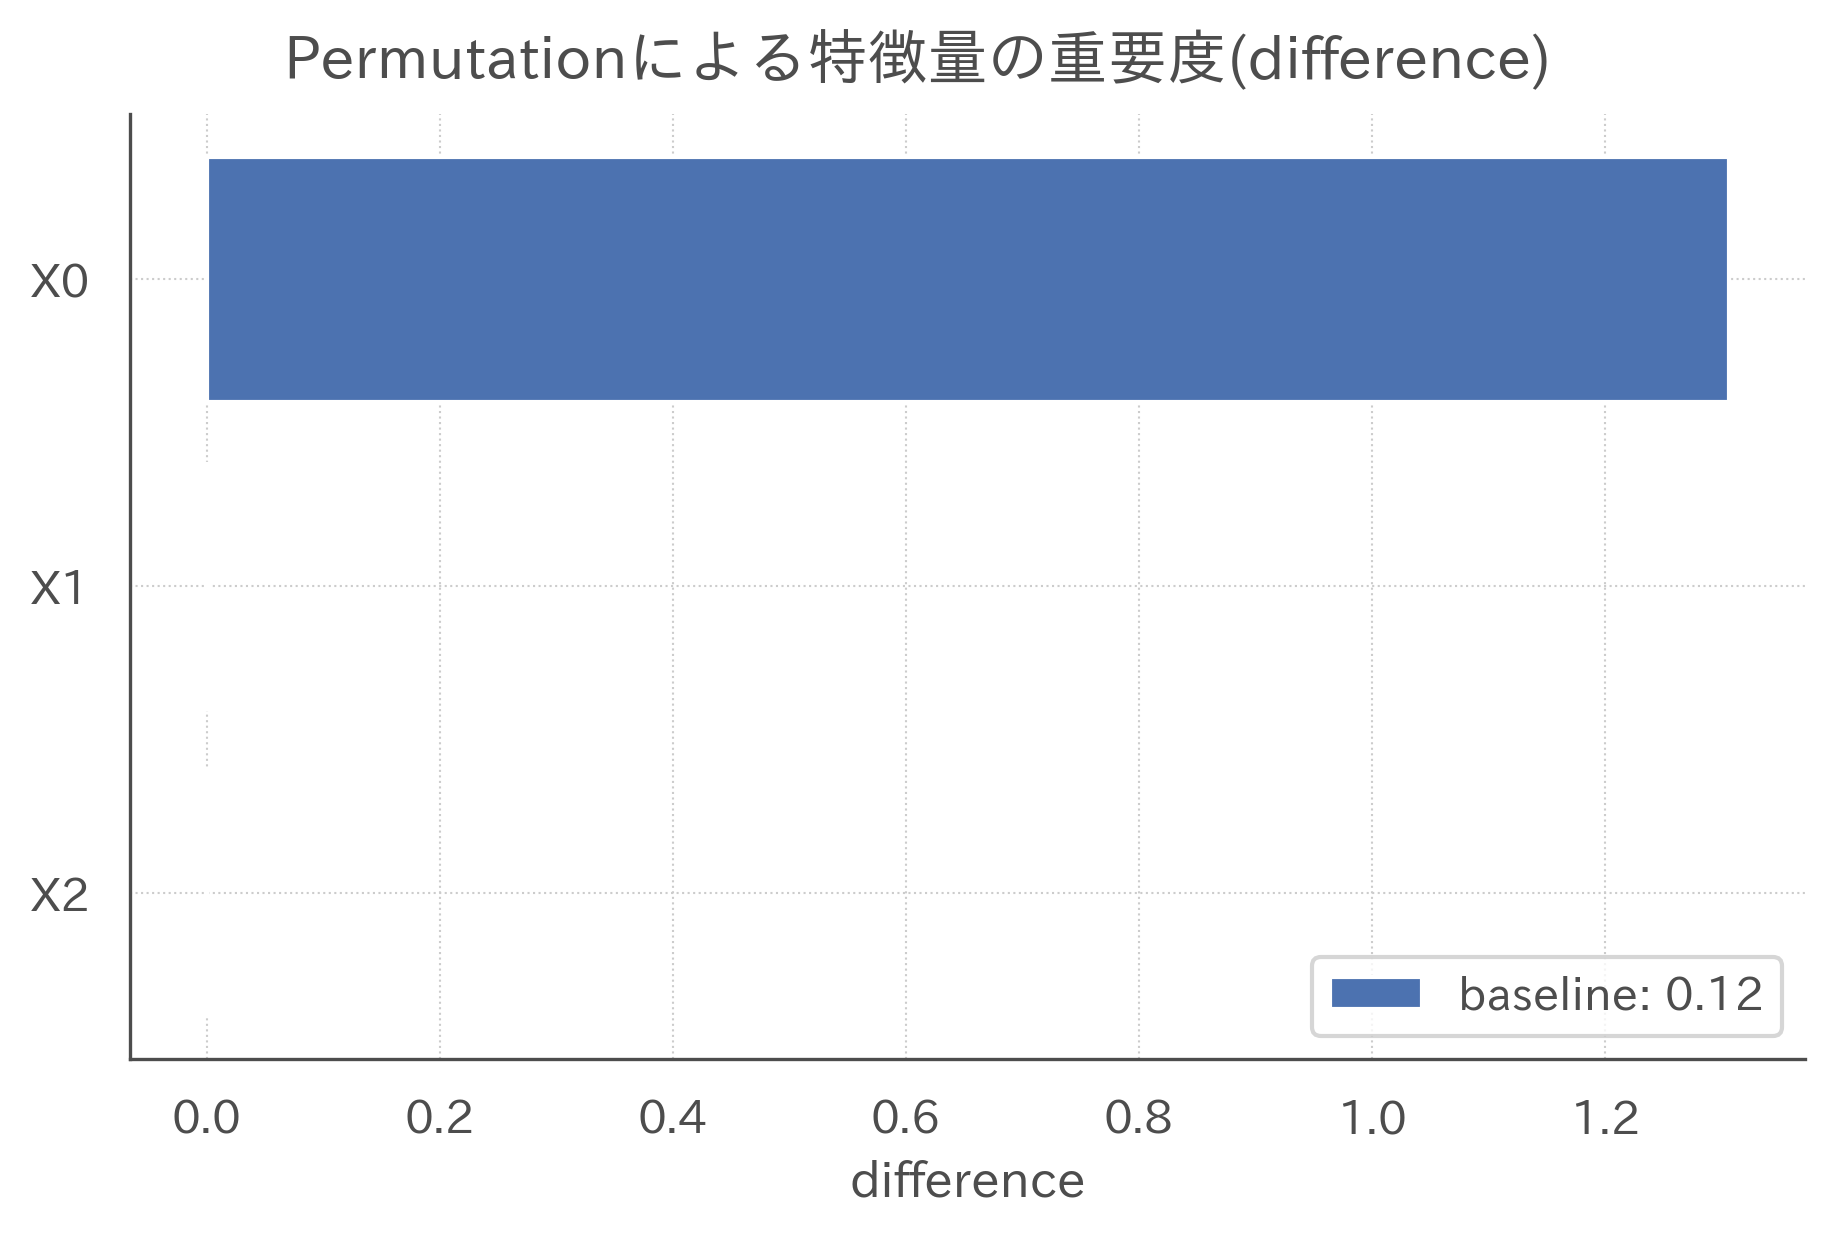

In [19]:
# 全特徴量を使ってRandom Forestの予測モデルを構築
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train, y_train)

# PFIを計算
var_names = [f"X{j}" for j in range(J)]
pfi = PermutationFeatureImportance(rf, X_test, y_test, var_names)
pfi.permutation_feature_importance()

# PFIを可視化
pfi.plot(importance_type='difference')

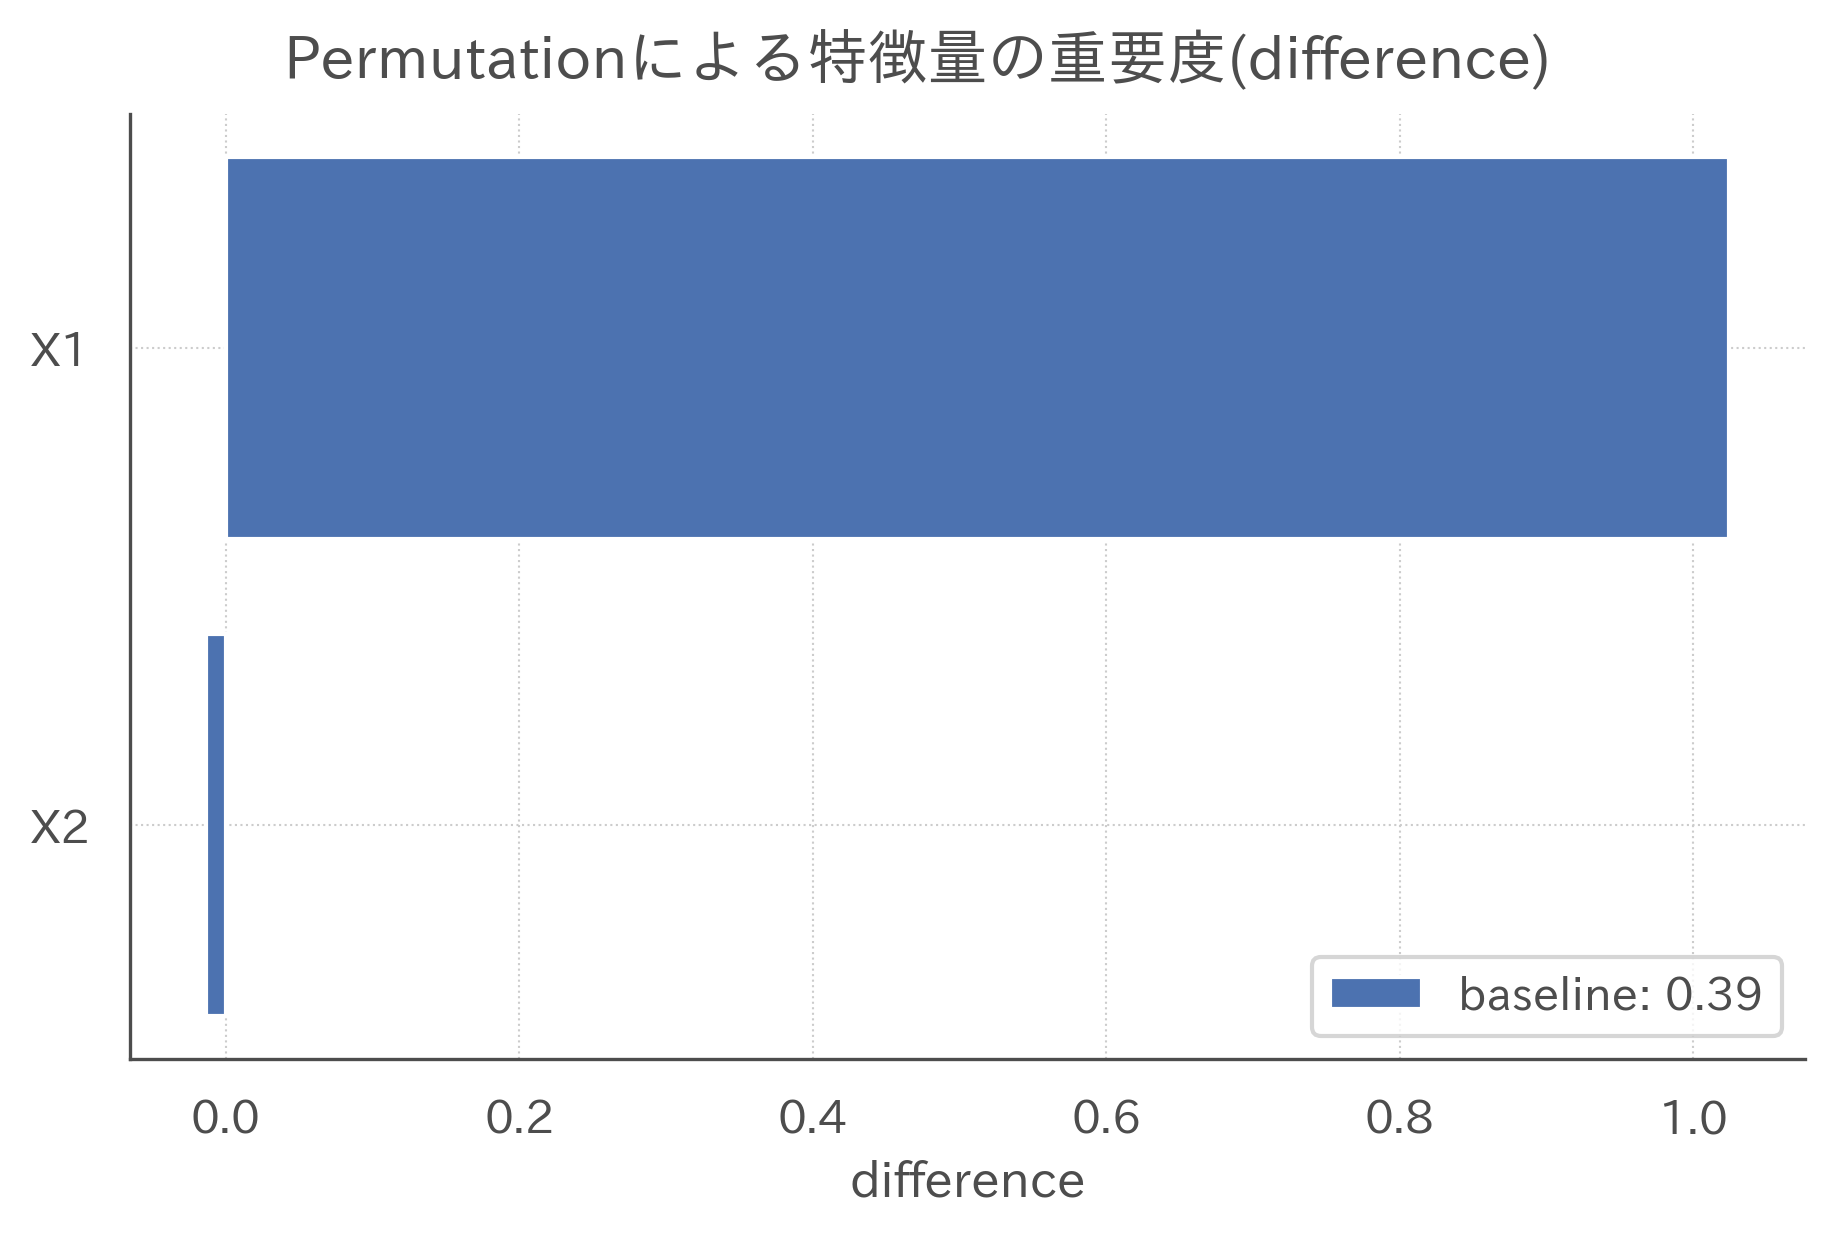

In [20]:
# X0は使わずモデルを構築
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train[:, [1, 2]], y_train)

# PFIを計算
pfi = PermutationFeatureImportance(rf, X_test[:, [1, 2]], y_test, ['X1', 'X2'])
pfi.permutation_feature_importance()

# PFIを可視化
pfi.plot(importance_type='difference')

### 訓練データとテストデータのどちらで予測精度を評価するべきか

In [30]:
def plot_bar(variables, values, title=None, xlabel=None, ylabel=None):
    """回帰係数の大きさを確認する棒グラフを作成"""
    
    fig, ax = plt.subplots()
    ax.barh(variables, values)
    ax.set(xlabel=xlabel, ylabel=ylabel, xlim=(0, None))
    fig.suptitle(title)
    
    fig.show()

In [24]:
# 実データでの分析
X_train, X_test, y_train, y_test = joblib.load('data/boston_housing.pkl')
rf = joblib.load('model/boston_housing_rf.pkl')


In [28]:
pfi = permutation_importance(
    estimator = rf,
    X = X_test,
    y = y_test,
    scoring = 'neg_root_mean_squared_error',
    n_repeats = 5,
    n_jobs = -1,
    random_state = 42
)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without featu

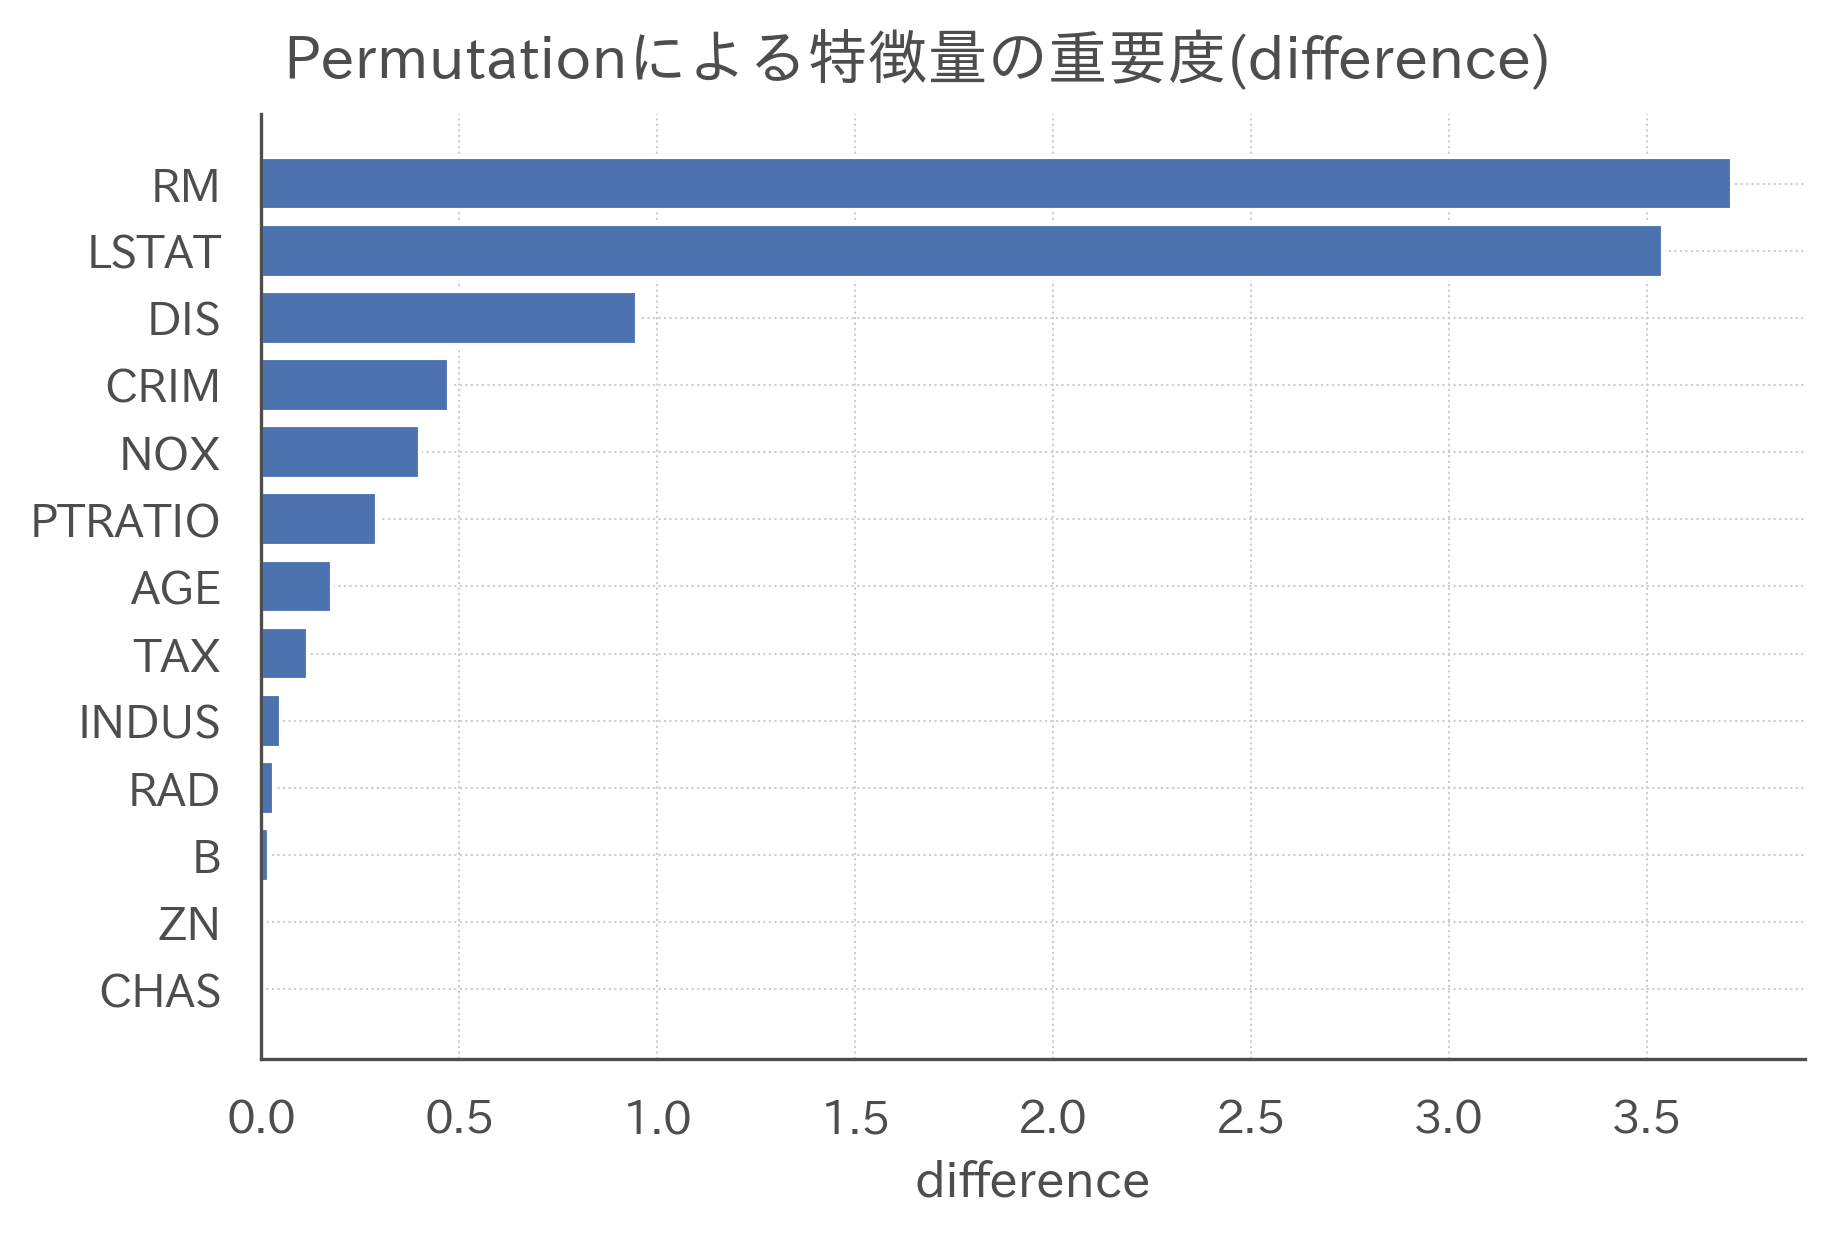

In [31]:
# PFIを可視化するために、特徴量の名前と重要度を対応させたデータフレームを作成
df_pfi = pd.DataFrame(
    data = {'var_name': X_test.columns, 'importance': pfi['importances_mean']}
).sort_values('importance')

# PFIを可視化
plot_bar(
    df_pfi['var_name'],
    df_pfi['importance'],
    xlabel = 'difference',
    title = 'Permutationによる特徴量の重要度(difference)'
)